In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

Задание

*   Выберите ряд из первого задания.
*   Постройте его модель GARCH.
*   Оформите отчёт в Jupyter-ноутбук.

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
# возмем ежемесячные продажи компании x

series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv").iloc[:,-1]
series.head()

0    154
1     96
2     73
3     49
4     36
Name: Count, dtype: int64

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


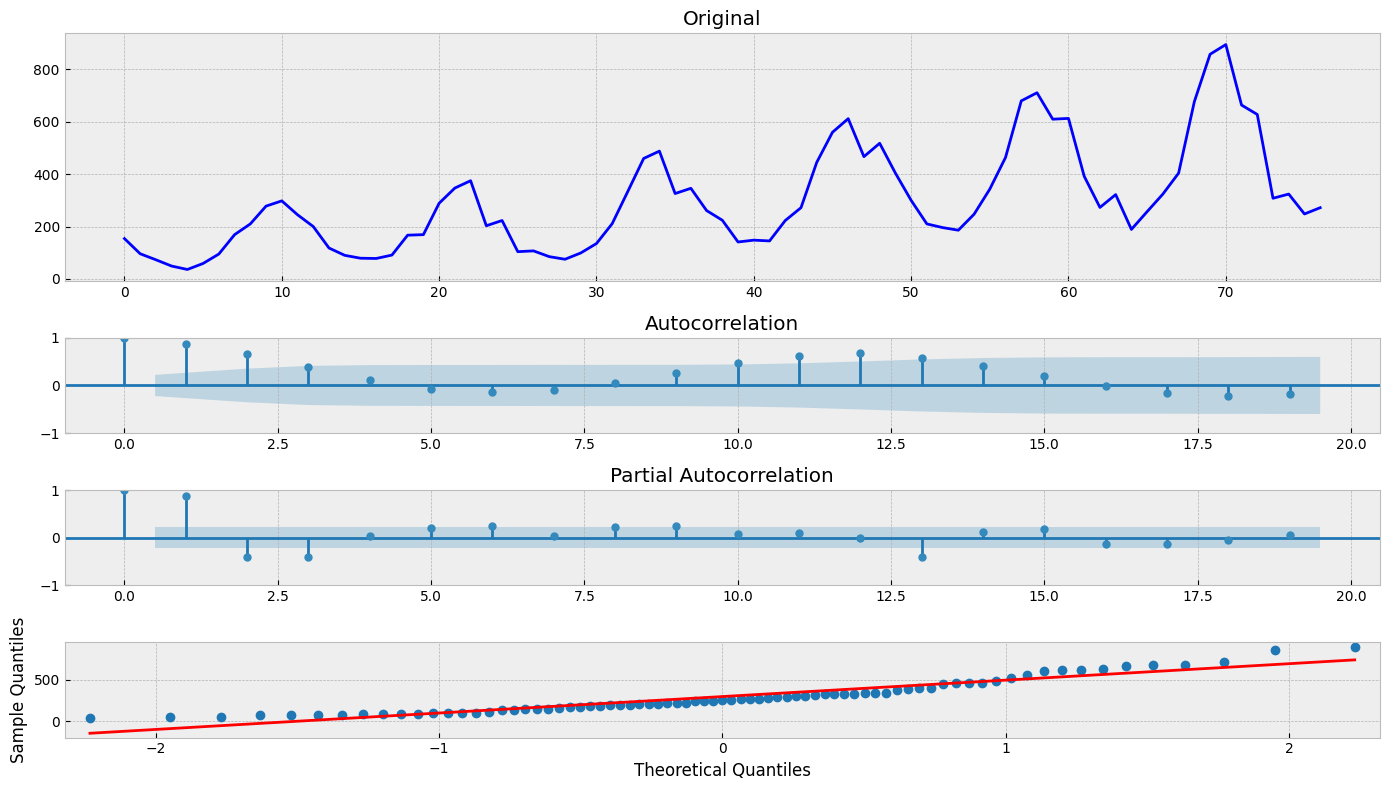

In [6]:
tsplot(series)

## GARCH

In [7]:
from arch import arch_model

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


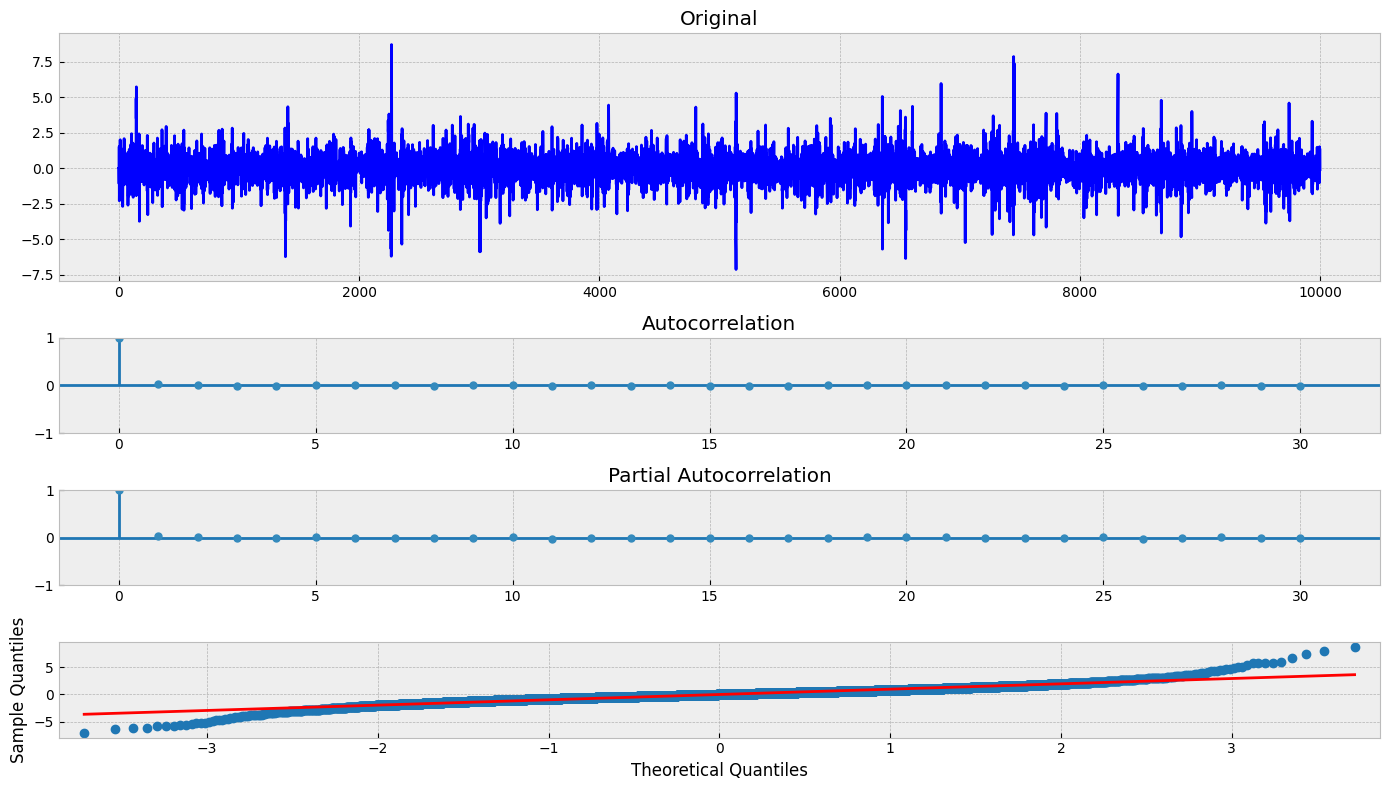

In [10]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

In [11]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.790134449831
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312781716888
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267318712
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sat, Oct 21 2023   Df Residuals:                     9999
Time:       

In [17]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic:    inf | order: None


In [13]:
tsplot(mdl.resid)

AttributeError: 'NoneType' object has no attribute 'resid'